# Pokemon Stat Predictor

This is a project that takes known data about Pokemon species from the Pokemon video games and creates a database of average stats based on typing.

The data used for this project was imported from Bulbapedia (https://bulbapedia.bulbgarden.net) and uses Pokemon through generation VII to calculate the averages. Bulbapedia was chosen for its large number of html tables on Pokemon and for its mostly consistent formatting across the site.

For simplicity's sake, Mega Pokemon are excluded as are pokemon with alternate forms (formes) such as Deoxys, Rotom, Aegislash, etc. Alolan variants are included in the dataset. Part of the reasoning behind these choices is how Bulbapedia has stored their pokemon data: In their table for Pokemon typing, Mega Pokemon are absent. Alolan variants appear after their original Kanto forms and can be identified by the lack of a Kanto Pokedex number or by the repeat of the National Pokedex number. More info on the table discrepancies can be found below.

This notebook contains examples of webscraping, data cleaning, and use of pandas dataframes.

This notebook project was inspired by this post from Medium on building a Pokedex: https://towardsdatascience.com/web-scraping-html-tables-with-python-c9baba21059

In [1]:
#imports
from lxml import html
import requests
import re
import pandas as pd

In [2]:
#First Table Download
url = 'https://bulbapedia.bulbagarden.net/wiki/List_of_Pok%C3%A9mon_by_base_stats_(Generation_VII-present)'
page = requests.get(url)
tree = html.fromstring(page.content)

In [3]:
#Function  for cleaning bulbapedia tables.
#This function definition needs to be cleaned up!
def bulbapedia_table_cleaner(input_lst):
    '''This function takes tr data separated by newline characters and modifies it into a comma separated
    Takes tr data from bulbapedia format and returns a dataframe.
    Expects a list to be turned into list of lists to be turned into df rows.
    input_lst: list with tr data. Should be a list with elements separated by commas.'''
    middle_lst = []
    last_lst = []
    for el in input_lst:
        cleaned = el.replace('\n\n ', ',')
        cleaned_2 = cleaned.replace(',,', ',')
        cleaned_3 = cleaned_2.replace('\n', '')

        middle_lst.append(cleaned_3)

    for el in middle_lst:
        split = el.split(',')
        last_lst.append(split)
    
    output_df = pd.DataFrame(last_lst)

    return output_df

In [4]:
#Parse tr elements of the HTML for your page
tr_elements = tree.xpath('//tr')

In [ ]:
#Checks for element length. Helps determine if you scraped more than one table.
#I checked the first 12 and last 12 elements of the table. You can un-comment out the below lines to 
# see the length of the elements. Based on this sampling, it looks like the length of 11 is the main
# main table from our website.
#[len(el) for el in tr_elements[:12]]
#[len(el) for el in tr_elements[-13:-1]]

In [5]:
pkmn_bst_table_rows = []

for el in tr_elements:
    if len(el) == 11:
        row = el.text_content()
        pkmn_bst_table_rows.append(row)

In [ ]:
#Run this cell to see the default text in the table from Bulbapedia.
#You should see a lot of /n characters, which is what the bulbapedia_table_cleaner
# function is designed to take out of the dataset.
pkmn_bst_table_rows

In [ ]:
#Declare new list variable as an empty list for loading into the dataframe.
#Is this still necessary? I don't think I used this in the final version of the table cleaner function...
pkmn_bst_df_rows = []

In [6]:
#Declare new, empty dataframe for function
pkmn_bst_df = pd.DataFrame()

In [7]:
pkmn_bst_df = bulbapedia_table_cleaner(pkmn_bst_table_rows)

In [8]:
pkmn_bst_df.head()

,0,1,2,3,4,5,6,7,8,9
0,#,Pokémon,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Total,Average
1,001,Bulbasaur,45,49,49,65,65,45,318,53
2,002,Ivysaur,60,62,63,80,80,60,405,67.5
3,003,Venusaur,80,82,83,100,100,80,525,87.5
4,003,Venusaur (Mega Venusaur),80,100,123,122,120,80,625,104.17


In [9]:
#Promote first row of df to headers
header_row = pkmn_bst_df.iloc[0]
pkmn_bst_df = pkmn_bst_df[1:]
pkmn_bst_df.columns = header_row

In [10]:
pkmn_bst_df.head()

,#,Pokémon,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Total,Average
1,001,Bulbasaur,45,49,49,65,65,45,318,53
2,002,Ivysaur,60,62,63,80,80,60,405,67.5
3,003,Venusaur,80,82,83,100,100,80,525,87.5
4,003,Venusaur (Mega Venusaur),80,100,123,122,120,80,625,104.17
5,004,Charmander,39,52,43,60,50,65,309,51.5


There is a discrepancy in how bulbapedia has listed pokemon between  their two tables.

In the bst table, pokemon and their alternate forms are listed (eg. "Venausaur" and "Venusaur (Mega Venusaur)"). This is not an issue for Mega Pokemon or Alolan Forms because the default or original form is captured.

However, this is an issue for pokemon that only have "alternate" forms, such as Deoxys and Wormadam. This causes these pokemon to be entirely excluded from the merged dataframe because there are no matching values between the bst table and the type table.

Run the cell below to see an example of the Deoxys data from the bst table.

This project will attempt to exculde all megas from the calculations, but will include Alolan forms and alternate forms.

In [ ]:
pkmn_bst_df[444:454]

In [ ]:
pkmn_bst_df[55:65]

In [ ]:
pkmn_bst_df[55:65].isin({'Pokémon':[]})

In [11]:
pkmn_bst_df[['Pokémon', 'Variant']] = pkmn_bst_df['Pokémon'].str.split('(',expand=True)

In [12]:
pkmn_bst_df.head()

,#,Pokémon,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Total,Average,Variant
1,001,Bulbasaur,45,49,49,65,65,45,318,53,None
2,002,Ivysaur,60,62,63,80,80,60,405,67.5,None
3,003,Venusaur,80,82,83,100,100,80,525,87.5,None
4,003,Venusaur,80,100,123,122,120,80,625,104.17,Mega Venusaur)
5,004,Charmander,39,52,43,60,50,65,309,51.5,None


In [13]:
def bulbapedia_form_finder(row):
    if row['Variant'] == None:
        value = row['Pokémon']
    elif "Mega" in row['Variant']:
        value = "Mega"
    elif "Alolan" in row['Variant']:
        value = "Alolan "+row['Pokémon']
    elif "Wormdam" in row['Pokémon']:
        value = row['Pokémon']+row['Variant'].str.split(' ')
    else:
        value = row['Pokémon']
    return value

In [14]:
pkmn_bst_df['Updated_Name'] = pkmn_bst_df.apply(bulbapedia_form_finder, axis=1)

In [15]:
#clean all of the string data from trailing spaces introduced in the split above
pkmn_bst_df['Updated_Name'] = pkmn_bst_df['Updated_Name'].str.strip()

In [16]:
pkmn_bst_df['Pokémon'] = pkmn_bst_df['Pokémon'].str.strip()

In [17]:
pkmn_bst_df.head()

,#,Pokémon,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Total,Average,Variant,Updated_Name
1,001,Bulbasaur,45,49,49,65,65,45,318,53,None,Bulbasaur
2,002,Ivysaur,60,62,63,80,80,60,405,67.5,None,Ivysaur
3,003,Venusaur,80,82,83,100,100,80,525,87.5,None,Venusaur
4,003,Venusaur,80,100,123,122,120,80,625,104.17,Mega Venusaur),Mega
5,004,Charmander,39,52,43,60,50,65,309,51.5,None,Charmander


In [ ]:
pkmn_bst_df[60:69]

In [ ]:
pkmn_bst_df.Updated_Name = pkmn_bst_df.Updated_Name.str.encode('utf-8')

In [ ]:
pkmn_bst_df[60:69]

In [ ]:
pkmn_bst_df[65:75].isin({'Updated_Name':['Meowth']})

Because the second table we're using records all pokemon as only the base pokemon name, we will need a way to intuit the actual pokemon, including forms/regional variants, and match the correct typing.

Should start by looking at the type table and limit to the rows where the nat_dex number is the same as the preceeding nat_dex number (same pokemon).

Will have to know the order and typing for each (Deoxys, Wormadam, Unova Genies)

In [18]:
#Second Table Download
url_2 = 'https://bulbapedia.bulbagarden.net/wiki/List_of_Pok%C3%A9mon_by_index_number_(Generation_VII)'
page_2 = requests.get(url_2)
tree_2 = html.fromstring(page_2.content)

In [19]:
tr_elements_2 = tree_2.xpath('//tr')

In [ ]:
#Checks for element length. Helps determine if you scraped more than one table.
#[len(el) for el in tr_elements_2[:12]]
#[len(el) for el in tr_elements_2[-12:-1]]

In [20]:
pkmn_type_table_rows = []

for el in tr_elements_2:
    if len(el) == 6:
        row = el.text_content()
        pkmn_type_table_rows.append(row)

In [21]:
#Currently, the type table does not have headers.
#Have to put headers into the dataframe so that I can join data frames.
#Create new list to concatenate with the data list prior to running the table cleaner function.
#Make sure to use accented é character in  "Pokémon"
pkmn_type_table_header = ['Bulb_Index,Nat_Dex,Pokémon,Type1,Type2']

In [22]:
pkmn_type_table_rows = pkmn_type_table_header+pkmn_type_table_rows

In [23]:
pkmn_type_df = bulbapedia_table_cleaner(pkmn_type_table_rows)

In [24]:
pkmn_type_df.head()

,0,1,2,3,4
0,Bulb_Index,Nat_Dex,Pokémon,Type1,Type2
1,001,001,Bulbasaur,Grass,Poison
2,002,002,Ivysaur,Grass,Poison
3,003,003,Venusaur,Grass,Poison
4,004,004,Charmander,Fire,Fire


In [25]:
#Promote first row of df to headers
header_row = pkmn_type_df.iloc[0]
pkmn_type_df = pkmn_type_df[1:]
pkmn_type_df.columns = header_row

In [26]:
pkmn_type_df.head()

,Bulb_Index,Nat_Dex,Pokémon,Type1,Type2
1,001,001,Bulbasaur,Grass,Poison
2,002,002,Ivysaur,Grass,Poison
3,003,003,Venusaur,Grass,Poison
4,004,004,Charmander,Fire,Fire
5,005,005,Charmeleon,Fire,Fire


In [27]:
pkmn_type_df[50:59]

,Bulb_Index,Nat_Dex,Pokémon,Type1,Type2
51,033,051,Dugtrio,Ground,Ground
52,034,052,Meowth,Normal,Normal
53,035,053,Persian,Normal,Normal
54,036,054,Psyduck,Water,Water
55,037,055,Golduck,Water,Water
56,038,056,Mankey,Fighting,Fighting
57,039,057,Primeape,Fighting,Fighting
58,03A,058,Growlithe,Fire,Fire
59,03B,059,Arcanine,Fire,Fire


The pkmn_type_df does not have type data for Alolan variants of pokemon.

I am not sure what the best solution is. I think it may be to specifically write/append the Alolan type data to the dataframe itself.

In [28]:
alolan_type_df = pd.DataFrame([[19, 'Alolan Rattata', 'Dark', 'Normal'], 
                              [20, 'Alolan Raticate', 'Dark', 'Normal'], 
                              [26, 'Alolan Raichu', 'Electric', 'Psychic'],
                              [27, 'Alolan Sandshrew', 'Ice', 'Steel'],
                              [28, 'Alolan Sandslash', 'Ice', 'Steel'],
                              [37, 'Alolan Vulpix', 'Ice', 'Ice'],
                              [38, 'Alolan Ninetails', 'Ice', 'Fairy'],
                              [50, 'Alolan Diglett', 'Ground', 'Steel'],
                              [51, 'Alolan Dugtrio', 'Ground', 'Steel'],
                              [52, 'Alolan Meowth', 'Dark', 'Dark'],
                              [53, 'Alolan Persian', 'Dark', 'Dark'],
                              [74, 'Alolan Geodude', 'Rock', 'Electric'],
                              [75, 'Alolan Graveler', 'Rock', 'Electric'],
                              [76, 'Alolan Golem', 'Rock', 'Electric'],
                              [88, 'Alolan Grimer', 'Poison', 'Dark'],
                              [89, 'Alolan Muk', 'Poison', 'Dark'],
                              [103, 'Alolan Exeggutor', 'Grass', 'Dragon'],
                              [105, 'Alolan Marowak', 'Fire', 'Ghost']],
                              columns=['Nat_Dex','Pokémon','Type1','Type2'])

In [29]:
new_pkmn_type_df = pkmn_type_df.append(alolan_type_df, ignore_index=True, sort=False)

In [ ]:
new_pkmn_type_df.Pokémon = new_pkmn_type_df.Pokémon.str.encode('utf-8')

In [ ]:
new_pkmn_type_df.dtypes

In [ ]:
new_pkmn_type_df

In [30]:
pkmn_full_df = pd.merge(pkmn_bst_df, new_pkmn_type_df, left_on='Updated_Name', right_on='Pokémon')

In [ ]:
#pkmn_full_df = pkmn_bst_df.merge(new_pkmn_type_df, left_on='Updated_Name', right_on='Pokémon')

In [ ]:
#pkmn_full_df = pd.merge(pkmn_bst_df, new_pkmn_type_df, left_on='Updated_Name', right_on='Pokémon')

In [31]:
#merge is only returning rows with matches.
#Excludes Mega Pokemon (should be the correct thing to do).
#However, need to check the dex numbers and see which columns were actually dex numbers and which were indexes.
pkmn_full_df

,#,Pokémon_x,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Total,Average,Variant,Updated_Name,Bulb_Index,Nat_Dex,Pokémon_y,Type1,Type2
0,001,Bulbasaur,45,49,49,65,65,45,318,53,None,Bulbasaur,001,001,Bulbasaur,Grass,Poison
1,002,Ivysaur,60,62,63,80,80,60,405,67.5,None,Ivysaur,002,002,Ivysaur,Grass,Poison
2,003,Venusaur,80,82,83,100,100,80,525,87.5,None,Venusaur,003,003,Venusaur,Grass,Poison
3,004,Charmander,39,52,43,60,50,65,309,51.5,None,Charmander,004,004,Charmander,Fire,Fire
4,005,Charmeleon,58,64,58,80,65,80,405,67.5,None,Charmeleon,005,005,Charmeleon,Fire,Fire
5,006,Charizard,78,84,78,109,85,100,534,89,None,Charizard,006,006,Charizard,Fire,Flying
6,007,Squirtle,44,48,65,50,64,43,314,52.33,None,Squirtle,007,007,Squirtle,Water,Water
7,008,Wartortle,59,63,80,65,80,58,405,67.5,None,Wartortle,008,008,Wartortle,Water,Water
8,009,Blastoise,79,83,100,85,105,78,530,88.33,None,Blastoise,009,009,Blastoise,Water,Water
9,010,Caterpie,45,30,35,20,20,45,195,32.5,None,Caterpie,00A,010,Caterpie,Bug,Bug


In [ ]:
pkmn_full_df[50:59]

In [ ]:
pkmn_full_df.Pokémon_x = pkmn_full_df.Pokémon_x.str.encode('utf-8')

In [ ]:
pkmn_full_df[pkmn_full_df.Pokémon_y.isin(["Alolan Diglett"])]

In [ ]:
pkmn_full_df.index

In [ ]:
pkmn_full_df.Nat_Dex = pd.to_numeric(pkmn_full_df.Nat_Dex)

In [ ]:
pkmn_full_df

In [ ]:
# at turtwig, index switches to being 2 behind (index = 385, Dex = 387)
# at Burmy/Mothim (Nat_Dex = 412,414), index switches to being 3 behind (index = 411, Dex = 414)
# by Drampa (Nat_Dex = 780), index is 14 behind (index = 766, Dex = 780)
# Offset stays at 14 til end of pokemon. See Melmetal (index = 795, Dex = 809)
pkmn_full_df.query('Nat_Dex != (index+1)')

In [ ]:
pkmn_full_df[380:389]

In [ ]:
#Error comes from the merging with special "forme" pokemon.
#Deoxys is missing from the pkmn_full_df because it 
#is recorded as "Deoxys (Normal Forme)" in the bst_df and "Deoxys" in the type_df
pkmn_bst_df[440:459]

Comparing pokemon by type alone is not a good method for determining avevrage stats. Pokemon species go through the process of evolution to become stronger. Naturally, the higher a pokemon's evolutionary stage the higher its stats are.

I could not find a satisfactory dataset of pokemon by their evolutionary stage, so I composed my own in .csv format. The stages used are: basic, stage 1, stage 2, baby, legendary, mega, and ultra beast.

In [32]:
stages_raw = open("pokemon stages.csv", "r")

In [33]:
stages_read = stages_raw.read()

In [34]:
stages_split = stages_read.split("\n")

In [35]:
stages_split

['dex #,Pokemon,Stage',
 '1,Bulbasaur,basic',
 '2,Ivysaur,stage 1',
 '3,Venusaur,stage 2',
 '3,Venusaur (Mega Venusaur),mega',
 '4,Charmander,basic',
 '5,Charmeleon,stage 1',
 '6,Charizard,stage 2',
 '6,Charizard (Mega Charizard X),mega',
 '6,Charizard (Mega Charizard Y),mega',
 '7,Squirtle,basic',
 '8,Wartortle,stage 1',
 '9,Blastoise,stage 2',
 '9,Blastoise (Mega Blastoise),mega',
 '10,Caterpie,basic',
 '11,Metapod,stage 1',
 '12,Butterfree,stage 2',
 '13,Weedle,basic',
 '14,Kakuna,stage 1',
 '15,Beedrill,stage 2',
 '15,Beedrill (Mega Beedrill),mega',
 '16,Pidgey,basic',
 '17,Pidgeotto,stage 1',
 '18,Pidgeot,stage 2',
 '18,Pidgeot (Mega Pidgeot),mega',
 '19,Rattata,basic',
 '19,Rattata (Alolan Rattata),basic',
 '20,Raticate,stage 1',
 '20,Raticate (Alolan Raticate),stage 1',
 '21,Spearow,basic',
 '22,Fearow,stage 1',
 '23,Ekans,basic',
 '24,Arbok,stage 1',
 '25,Pikachu,basic',
 '25,Pikachu (Partner Pikachu),basic',
 '26,Raichu,stage 1',
 '26,Raichu (Alolan Raichu),stage 1',
 '27,Sand

In [36]:
def makes_list_of_lists(input_lst):
    output_list = []

    for el in input_lst:
        list_split = el.split(",")
        output_list.append(list_split)
    return output_list

In [37]:
pkmn_stages_data = makes_list_of_lists(stages_split)

In [38]:
pkmn_stages_df = pd.DataFrame(pkmn_stages_data)

In [39]:
pkmn_stages_df.head()

,0,1,2
0,dex #,Pokemon,Stage
1,1,Bulbasaur,basic
2,2,Ivysaur,stage 1
3,3,Venusaur,stage 2
4,3,Venusaur (Mega Venusaur),mega


In [40]:
#Promote first row of df to headers
header_row = pkmn_stages_df.iloc[0]
pkmn_stages_df = pkmn_stages_df[1:]
pkmn_stages_df.columns = header_row

In [ ]:
pkmn_stages_df.dtypes

In [ ]:
pkmn_stages_df.Pokemon = pkmn_stages_df.Pokemon.str.encode('utf-8')

In [41]:
pkmn_stages_df

,dex #,Pokemon,Stage
1,1,Bulbasaur,basic
2,2,Ivysaur,stage 1
3,3,Venusaur,stage 2
4,3,Venusaur (Mega Venusaur),mega
5,4,Charmander,basic
6,5,Charmeleon,stage 1
7,6,Charizard,stage 2
8,6,Charizard (Mega Charizard X),mega
9,6,Charizard (Mega Charizard Y),mega
10,7,Squirtle,basic


In [42]:
pkmn_final_df = pd.merge(pkmn_full_df, pkmn_stages_df, how='left', left_on='Pokémon_x', right_on='Pokemon')

In [43]:
pkmn_final_df

,#,Pokémon_x,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Total,Average,Variant,Updated_Name,Bulb_Index,Nat_Dex,Pokémon_y,Type1,Type2,dex #,Pokemon,Stage
0,001,Bulbasaur,45,49,49,65,65,45,318,53,None,Bulbasaur,001,001,Bulbasaur,Grass,Poison,1,Bulbasaur,basic
1,002,Ivysaur,60,62,63,80,80,60,405,67.5,None,Ivysaur,002,002,Ivysaur,Grass,Poison,2,Ivysaur,stage 1
2,003,Venusaur,80,82,83,100,100,80,525,87.5,None,Venusaur,003,003,Venusaur,Grass,Poison,3,Venusaur,stage 2
3,004,Charmander,39,52,43,60,50,65,309,51.5,None,Charmander,004,004,Charmander,Fire,Fire,4,Charmander,basic
4,005,Charmeleon,58,64,58,80,65,80,405,67.5,None,Charmeleon,005,005,Charmeleon,Fire,Fire,5,Charmeleon,stage 1
5,006,Charizard,78,84,78,109,85,100,534,89,None,Charizard,006,006,Charizard,Fire,Flying,6,Charizard,stage 2
6,007,Squirtle,44,48,65,50,64,43,314,52.33,None,Squirtle,007,007,Squirtle,Water,Water,7,Squirtle,basic
7,008,Wartortle,59,63,80,65,80,58,405,67.5,None,Wartortle,008,008,Wartortle,Water,Water,8,Wartortle,stage 1
8,009,Blastoise,79,83,100,85,105,78,530,88.33,None,Blastoise,009,009,Blastoise,Water,Water,9,Blastoise,stage 2
9,010,Caterpie,45,30,35,20,20,45,195,32.5,None,Caterpie,00A,010,Caterpie,Bug,Bug,10,Caterpie,basic


In [ ]:
pkmn_final_df[50:59]

In [44]:
not_legendary_df = pkmn_final_df[(pkmn_final_df.Stage != "legendary") & (pkmn_final_df.Stage != "ultra beast")]

In [45]:
not_legendary_df

,#,Pokémon_x,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Total,Average,Variant,Updated_Name,Bulb_Index,Nat_Dex,Pokémon_y,Type1,Type2,dex #,Pokemon,Stage
0,001,Bulbasaur,45,49,49,65,65,45,318,53,None,Bulbasaur,001,001,Bulbasaur,Grass,Poison,1,Bulbasaur,basic
1,002,Ivysaur,60,62,63,80,80,60,405,67.5,None,Ivysaur,002,002,Ivysaur,Grass,Poison,2,Ivysaur,stage 1
2,003,Venusaur,80,82,83,100,100,80,525,87.5,None,Venusaur,003,003,Venusaur,Grass,Poison,3,Venusaur,stage 2
3,004,Charmander,39,52,43,60,50,65,309,51.5,None,Charmander,004,004,Charmander,Fire,Fire,4,Charmander,basic
4,005,Charmeleon,58,64,58,80,65,80,405,67.5,None,Charmeleon,005,005,Charmeleon,Fire,Fire,5,Charmeleon,stage 1
5,006,Charizard,78,84,78,109,85,100,534,89,None,Charizard,006,006,Charizard,Fire,Flying,6,Charizard,stage 2
6,007,Squirtle,44,48,65,50,64,43,314,52.33,None,Squirtle,007,007,Squirtle,Water,Water,7,Squirtle,basic
7,008,Wartortle,59,63,80,65,80,58,405,67.5,None,Wartortle,008,008,Wartortle,Water,Water,8,Wartortle,stage 1
8,009,Blastoise,79,83,100,85,105,78,530,88.33,None,Blastoise,009,009,Blastoise,Water,Water,9,Blastoise,stage 2
9,010,Caterpie,45,30,35,20,20,45,195,32.5,None,Caterpie,00A,010,Caterpie,Bug,Bug,10,Caterpie,basic


In [46]:
not_legendary_df.drop(columns = ['Pokémon_x', 'Average', 'Variant', 'Bulb_Index', 'Pokémon_y', 'dex #', 'Pokemon'])

,#,HP,Attack,Defense,Sp. Attack,Sp. Defense,Speed,Total,Updated_Name,Nat_Dex,Type1,Type2,Stage
0,001,45,49,49,65,65,45,318,Bulbasaur,001,Grass,Poison,basic
1,002,60,62,63,80,80,60,405,Ivysaur,002,Grass,Poison,stage 1
2,003,80,82,83,100,100,80,525,Venusaur,003,Grass,Poison,stage 2
3,004,39,52,43,60,50,65,309,Charmander,004,Fire,Fire,basic
4,005,58,64,58,80,65,80,405,Charmeleon,005,Fire,Fire,stage 1
5,006,78,84,78,109,85,100,534,Charizard,006,Fire,Flying,stage 2
6,007,44,48,65,50,64,43,314,Squirtle,007,Water,Water,basic
7,008,59,63,80,65,80,58,405,Wartortle,008,Water,Water,stage 1
8,009,79,83,100,85,105,78,530,Blastoise,009,Water,Water,stage 2
9,010,45,30,35,20,20,45,195,Caterpie,010,Bug,Bug,basic


In [58]:
not_legendary_df.Total = pd.to_numeric(not_legendary_df.Total)

C:\Users\nmanh\Miniconda3\lib\site-packages\pandas\core\generic.py:5086: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [59]:
t1_stage_bst_mean_df = not_legendary_df.groupby(['Type1', 'Stage']).mean()

In [60]:
t1_stage_bst_mean_df 

Total
Type1    Stage              
Bug      basic    317.000000
         stage 1  400.607143
         stage 2  433.250000
Dark     basic    335.333333
         stage 1  475.642857
         stage 2  600.000000
Dragon   basic    329.285714
         stage 1  431.714286
         stage 2  590.000000
Electric baby     282.500000
         basic    459.264151
         stage 1  464.666667
         stage 2  520.750000
Fairy    baby     231.500000
         basic    365.833333
         stage 1  473.714286
         stage 2  552.000000
Fighting baby     247.500000
         basic    392.375000
         stage 1  454.000000
         stage 2  505.000000
Fire     baby     365.000000
         basic    359.800000
         stage 1  455.222222
         stage 2  527.875000
Flying   basic    245.000000
         stage 1  535.000000
Ghost    basic    364.000000
         stage 1  457.222222
         stage 2  515.000000
...                      ...
Grass    stage 2  502.714286
Ground   basic    330.266667
         stage 1  459.071429
         stage 2  524.666667
Ice      baby     305.000000
         basic    332.090909
         stage 1  467.666667
         stage 2  531.666667
Normal   baby     252.500000
         basic    349.315789
         stage 1  438.250000
         stage 2  516.500000
Poison   basic    322.571429
         stage 1  466.800000
         stage 2  515.000000
Psychic  baby     285.000000
         basic    344.812500
         stage 1  437.416667
         stage 2  503.200000
Rock     baby     290.000000
         basic    368.909091
         stage 1  478.933333
         stage 2  526.250000
Steel    basic    358.750000
         stage 1  458.000000
         stage 2  550.000000
Water    baby     345.000000
         basic    333.780000
         stage 1  462.279070
         stage 2  530.153846

[63 rows x 1 columns]

In [61]:
pivoted_df = t1_stage_bst_mean_df.pivot_table(values='Total', index='Type1', columns='Stage')

In [62]:
pivoted_df

Stage,baby,basic,stage 1,stage 2
Type1,,,,
Bug,NaN,317.000000,400.607143,433.250000
Dark,NaN,335.333333,475.642857,600.000000
Dragon,NaN,329.285714,431.714286,590.000000
Electric,282.5,459.264151,464.666667,520.750000
Fairy,231.5,365.833333,473.714286,552.000000
Fighting,247.5,392.375000,454.000000,505.000000
Fire,365.0,359.800000,455.222222,527.875000
Flying,NaN,245.000000,535.000000,NaN
Ghost,NaN,364.000000,457.222222,515.000000


In [55]:
pivoted_df.reset_index()

Stage,Type1,baby,basic,stage 1,stage 2
0,Bug,NaN,317.000000,400.607143,433.250000
1,Dark,NaN,335.333333,475.642857,600.000000
2,Dragon,NaN,329.285714,431.714286,590.000000
3,Electric,282.5,459.264151,464.666667,520.750000
4,Fairy,231.5,365.833333,473.714286,552.000000
5,Fighting,247.5,392.375000,454.000000,505.000000
6,Fire,365.0,359.800000,455.222222,527.875000
7,Flying,NaN,245.000000,535.000000,NaN
8,Ghost,NaN,364.000000,457.222222,515.000000
9,Grass,280.0,321.300000,437.800000,502.714286


In [ ]:
t1_stage_bst_mean_df.reset_index()

In [56]:
from matplotlib import pyplot

In [ ]:
t1_stage_bst_mean_df.plot.bar(stacked=True)

In [ ]:
pyplot.bar(x=t1_stage_bst_mean_df.Index[0:2],y=t1_stage_bst_mean_df.Total)

Start of Nathan's actual work on plotting things.
Don't mess with code above, that's not a good plot.

In [75]:
#pyplot.figure(figsize=(5,5))
#pyplot.bar(x=)

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

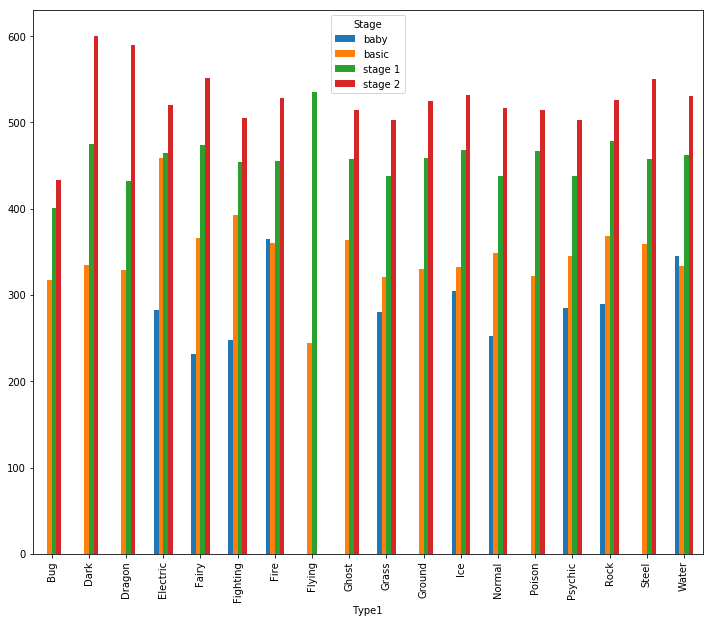

In [78]:
pivoted_df.plot(kind='bar', figsize=(12,10))